# ResNet

In [1]:
#Load necessary libraries
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim
import input_data
import matplotlib.pyplot as plt
%matplotlib inline

### Load CIFAR Dataset

To obtain the CIFAR10 dataset, go here: https://www.cs.toronto.edu/~kriz/cifar.html

The training data is stored in 5 separate files, and we will alternate between them during training.

In [2]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

In [3]:
currentCifar = 1
cifar = unpickle('./cifar10/data_batch_1')
cifarT = unpickle('./cifar10/test_batch')

In [4]:
total_layers = 25 #Specify how deep we want our network
units_between_stride = total_layers / 5

## ResNet
An implementation of a Residual Network as described in [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027).

In [5]:
def resUnit(input_layer,i):
    with tf.variable_scope("res_unit"+str(i)):
        part1 = slim.batch_norm(input_layer,activation_fn=None)
        part2 = tf.nn.relu(part1)
        part3 = slim.conv2d(part2,64,[3,3],activation_fn=None)
        part4 = slim.batch_norm(part3,activation_fn=None)
        part5 = tf.nn.relu(part4)
        part6 = slim.conv2d(part5,64,[3,3],activation_fn=None)
        output = input_layer + part6
        return output

tf.reset_default_graph()

input_layer = tf.placeholder(shape=[None,32,32,3],dtype=tf.float32,name='input')
label_layer = tf.placeholder(shape=[None],dtype=tf.int32)
label_oh = slim.layers.one_hot_encoding(label_layer,10)

layer1 = slim.conv2d(input_layer,64,[3,3],normalizer_fn=slim.batch_norm,scope='conv_'+str(0))
for i in range(5):
    for j in range(units_between_stride):
        layer1 = resUnit(layer1,j + (i*units_between_stride))
    layer1 = slim.conv2d(layer1,64,[3,3],stride=[2,2],normalizer_fn=slim.batch_norm,scope='conv_s_'+str(i))
    
top = slim.conv2d(layer1,10,[3,3],normalizer_fn=slim.batch_norm,activation_fn=None,scope='conv_top')

output = slim.layers.softmax(slim.layers.flatten(top))

loss = tf.reduce_mean(-tf.reduce_sum(label_oh * tf.log(output) + 1e-10, axis=[1]))
trainer = tf.train.AdamOptimizer(learning_rate=0.001)
update = trainer.minimize(loss)

### Visualize the network graph
We can call the Tensorflow Board to provide a graphical representation of our network.

In [6]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [7]:
show_graph(tf.get_default_graph().as_graph_def())

## Training

In [8]:
init = tf.global_variables_initializer()
batch_size = 64
currentCifar = 1
total_steps = 20000
l = []
a = []
aT = []
with tf.Session() as sess:
    sess.run(init)
    i = 0
    draw = range(10000)
    while i < total_steps:
        if i % (10000/batch_size) != 0:
            batch_index = np.random.choice(draw,size=batch_size,replace=False)
        else:
            draw = range(10000)
            if currentCifar == 5:
                currentCifar = 1
                print "Switched CIFAR set to " + str(currentCifar)
            else:
                currentCifar = currentCifar + 1
                print "Switched CIFAR set to " + str(currentCifar)
            cifar = unpickle('./cifar10/data_batch_'+str(currentCifar))
            batch_index = np.random.choice(draw,size=batch_size,replace=False)
        x = cifar['data'][batch_index]
        x = np.reshape(x,[batch_size,32,32,3],order='F')
        x = (x/256.0)
        x = (x - np.mean(x,axis=0)) / np.std(x,axis=0)
        y = np.reshape(np.array(cifar['labels'])[batch_index],[batch_size,1])
        _,lossA,yP,LO = sess.run([update,loss,output,label_oh],feed_dict={input_layer:x,label_layer:np.hstack(y)})
        accuracy = np.sum(np.equal(np.hstack(y),np.argmax(yP,1)))/float(len(y))
        l.append(lossA)
        a.append(accuracy)
        if i % 10 == 0: print "Step: " + str(i) + " Loss: " + str(lossA) + " Accuracy: " + str(accuracy)
        if i % 100 == 0: 
            point = np.random.randint(0,10000-500)
            xT = cifarT['data'][point:point+500]
            xT = np.reshape(xT,[500,32,32,3],order='F')
            xT = (xT/256.0)
            xT = (xT - np.mean(xT,axis=0)) / np.std(xT,axis=0)
            yT = np.reshape(np.array(cifarT['labels'])[point:point+500],[500])
            lossT,yP = sess.run([loss,output],feed_dict={input_layer:xT,label_layer:yT})
            accuracy = np.sum(np.equal(yT,np.argmax(yP,1)))/float(len(yT))
            aT.append(accuracy)
            print "Test set accuracy: " + str(accuracy)
        i+= 1

Switched CIFAR set to 2
Step: 0 Loss: 2.77905 Accuracy: 0.09375
Test set accuracy: 0.1
Step: 10 Loss: 2.18208 Accuracy: 0.171875
Step: 20 Loss: 2.21847 Accuracy: 0.140625
Step: 30 Loss: 2.39845 Accuracy: 0.140625
Step: 40 Loss: 2.46263 Accuracy: 0.21875
Step: 50 Loss: 2.04832 Accuracy: 0.28125
Step: 60 Loss: 1.91974 Accuracy: 0.296875
Step: 70 Loss: 1.98534 Accuracy: 0.3125
Step: 80 Loss: 1.89066 Accuracy: 0.28125
Step: 90 Loss: 1.81858 Accuracy: 0.328125
Step: 100 Loss: 1.98993 Accuracy: 0.25
Test set accuracy: 0.326
Step: 110 Loss: 1.80524 Accuracy: 0.4375
Step: 120 Loss: 1.71348 Accuracy: 0.359375
Step: 130 Loss: 1.93254 Accuracy: 0.25
Step: 140 Loss: 1.79573 Accuracy: 0.328125
Step: 150 Loss: 1.59047 Accuracy: 0.46875
Switched CIFAR set to 3
Step: 160 Loss: 1.74432 Accuracy: 0.359375
Step: 170 Loss: 1.5477 Accuracy: 0.46875
Step: 180 Loss: 1.76651 Accuracy: 0.296875
Step: 190 Loss: 1.78529 Accuracy: 0.359375
Step: 200 Loss: 1.77365 Accuracy: 0.359375
Test set accuracy: 0.428
Step: 

Step: 1760 Loss: 0.999436 Accuracy: 0.71875
Step: 1770 Loss: 0.962883 Accuracy: 0.75
Step: 1780 Loss: 0.767471 Accuracy: 0.84375
Step: 1790 Loss: 0.967283 Accuracy: 0.71875
Step: 1800 Loss: 0.858888 Accuracy: 0.75
Test set accuracy: 0.736
Step: 1810 Loss: 0.840895 Accuracy: 0.734375
Step: 1820 Loss: 1.01074 Accuracy: 0.75
Step: 1830 Loss: 1.00385 Accuracy: 0.734375
Step: 1840 Loss: 1.04692 Accuracy: 0.671875
Step: 1850 Loss: 1.12747 Accuracy: 0.671875
Step: 1860 Loss: 1.00974 Accuracy: 0.71875
Step: 1870 Loss: 0.907464 Accuracy: 0.765625
Switched CIFAR set to 4
Step: 1880 Loss: 1.0562 Accuracy: 0.625
Step: 1890 Loss: 0.944355 Accuracy: 0.703125
Step: 1900 Loss: 1.10782 Accuracy: 0.71875
Test set accuracy: 0.73
Step: 1910 Loss: 1.07401 Accuracy: 0.65625
Step: 1920 Loss: 0.860349 Accuracy: 0.796875
Step: 1930 Loss: 1.05268 Accuracy: 0.6875
Step: 1940 Loss: 1.04542 Accuracy: 0.703125
Step: 1950 Loss: 0.995495 Accuracy: 0.703125
Step: 1960 Loss: 0.800203 Accuracy: 0.796875
Step: 1970 Loss:

Step: 3480 Loss: 0.683632 Accuracy: 0.828125
Step: 3490 Loss: 0.726974 Accuracy: 0.8125
Step: 3500 Loss: 0.902355 Accuracy: 0.765625
Test set accuracy: 0.77
Step: 3510 Loss: 0.756176 Accuracy: 0.796875
Step: 3520 Loss: 0.868244 Accuracy: 0.75
Step: 3530 Loss: 0.65535 Accuracy: 0.875
Step: 3540 Loss: 0.841186 Accuracy: 0.75
Step: 3550 Loss: 0.757444 Accuracy: 0.703125
Step: 3560 Loss: 0.651477 Accuracy: 0.859375
Step: 3570 Loss: 0.755882 Accuracy: 0.828125
Step: 3580 Loss: 0.707111 Accuracy: 0.828125
Switched CIFAR set to 5
Step: 3590 Loss: 0.852712 Accuracy: 0.75
Step: 3600 Loss: 0.978012 Accuracy: 0.671875
Test set accuracy: 0.748
Step: 3610 Loss: 0.973044 Accuracy: 0.6875
Step: 3620 Loss: 0.854149 Accuracy: 0.765625
Step: 3630 Loss: 0.81518 Accuracy: 0.8125
Step: 3640 Loss: 1.12373 Accuracy: 0.71875
Step: 3650 Loss: 0.944653 Accuracy: 0.765625
Step: 3660 Loss: 0.755411 Accuracy: 0.8125
Step: 3670 Loss: 0.949447 Accuracy: 0.765625
Step: 3680 Loss: 0.690597 Accuracy: 0.859375
Step: 369

Step: 5190 Loss: 0.847664 Accuracy: 0.75
Step: 5200 Loss: 0.700207 Accuracy: 0.8125
Test set accuracy: 0.778
Step: 5210 Loss: 0.819401 Accuracy: 0.78125
Step: 5220 Loss: 0.674331 Accuracy: 0.84375
Step: 5230 Loss: 0.553993 Accuracy: 0.890625
Step: 5240 Loss: 0.682801 Accuracy: 0.859375
Step: 5250 Loss: 0.668563 Accuracy: 0.875
Step: 5260 Loss: 0.766851 Accuracy: 0.78125
Step: 5270 Loss: 0.591139 Accuracy: 0.875
Step: 5280 Loss: 0.588086 Accuracy: 0.859375
Step: 5290 Loss: 0.569518 Accuracy: 0.90625
Step: 5300 Loss: 0.561918 Accuracy: 0.875
Test set accuracy: 0.79
Switched CIFAR set to 1
Step: 5310 Loss: 0.842418 Accuracy: 0.796875
Step: 5320 Loss: 0.733156 Accuracy: 0.8125
Step: 5330 Loss: 0.692876 Accuracy: 0.84375
Step: 5340 Loss: 0.66236 Accuracy: 0.8125
Step: 5350 Loss: 0.735118 Accuracy: 0.78125
Step: 5360 Loss: 0.727404 Accuracy: 0.78125
Step: 5370 Loss: 0.612299 Accuracy: 0.828125
Step: 5380 Loss: 0.754548 Accuracy: 0.8125
Step: 5390 Loss: 0.763879 Accuracy: 0.8125
Step: 5400 Lo

KeyboardInterrupt: 

## Results

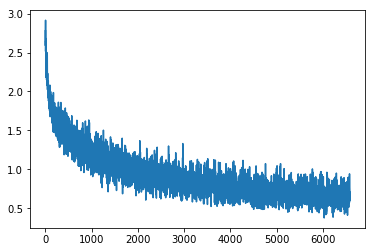

In [9]:
plt.plot(l) #Plot training loss

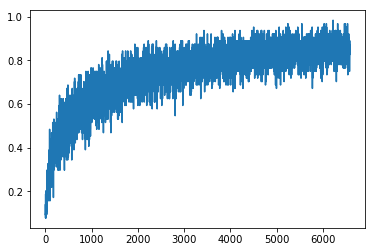

In [10]:
plt.plot(a) #Plot training accuracy

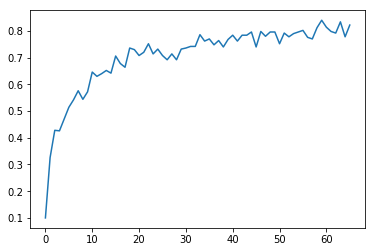

In [11]:
plt.plot(aT) #Plot test accuracy

In [12]:
np.max(aT) #Best test accuracy

0.83999999999999997